# Итоговый проект
Распознавание сердечно-сосудистых заболеваний

Импортируем библиотеки и модули для работы

In [27]:
import pandas as pd
from missingno import matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score, f1_score

Получение данных из датасета

In [28]:
df = pd.read_csv('cardio_train.csv', sep=';')
df.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

Информация о датасете

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Описательные статистики датасета

In [30]:
df.describe().T

count          mean           std      min       25%      50%  \
id           70000.0  49972.419900  28851.302323      0.0  25006.75  50001.5   
age          70000.0  19468.865814   2467.251667  10798.0  17664.00  19703.0   
gender       70000.0      1.349571      0.476838      1.0      1.00      1.0   
height       70000.0    164.359229      8.210126     55.0    159.00    165.0   
weight       70000.0     74.205690     14.395757     10.0     65.00     72.0   
ap_hi        70000.0    128.817286    154.011419   -150.0    120.00    120.0   
ap_lo        70000.0     96.630414    188.472530    -70.0     80.00     80.0   
cholesterol  70000.0      1.366871      0.680250      1.0      1.00      1.0   
gluc         70000.0      1.226457      0.572270      1.0      1.00      1.0   
smoke        70000.0      0.088129      0.283484      0.0      0.00      0.0   
alco         70000.0      0.053771      0.225568      0.0      0.00      0.0   
active       70000.0      0.803729      0.397179      0.0      1.00      1.0   
cardio       70000.0      0.499700      0.500003      0.0      0.00      0.0   

                  75%      max  
id           74889.25  99999.0  
age          21327.00  23713.0  
gender           2.00      2.0  
height         170.00    250.0  
weight          82.00    200.0  
ap_hi          140.00  16020.0  
ap_lo           90.00  11000.0  
cholesterol      2.00      3.0  
gluc             1.00      3.0  
smoke            0.00      1.0  
alco             0.00      1.0  
active           1.00      1.0  
cardio           1.00      1.0

Преобразуем данные датасета

In [31]:
# Удалим id пациента и целевую переменную из датасета

target_data = df['cardio']
df = df.drop(columns=['id', 'cardio'])

Визуализация пропусков датасета

<Axes: >

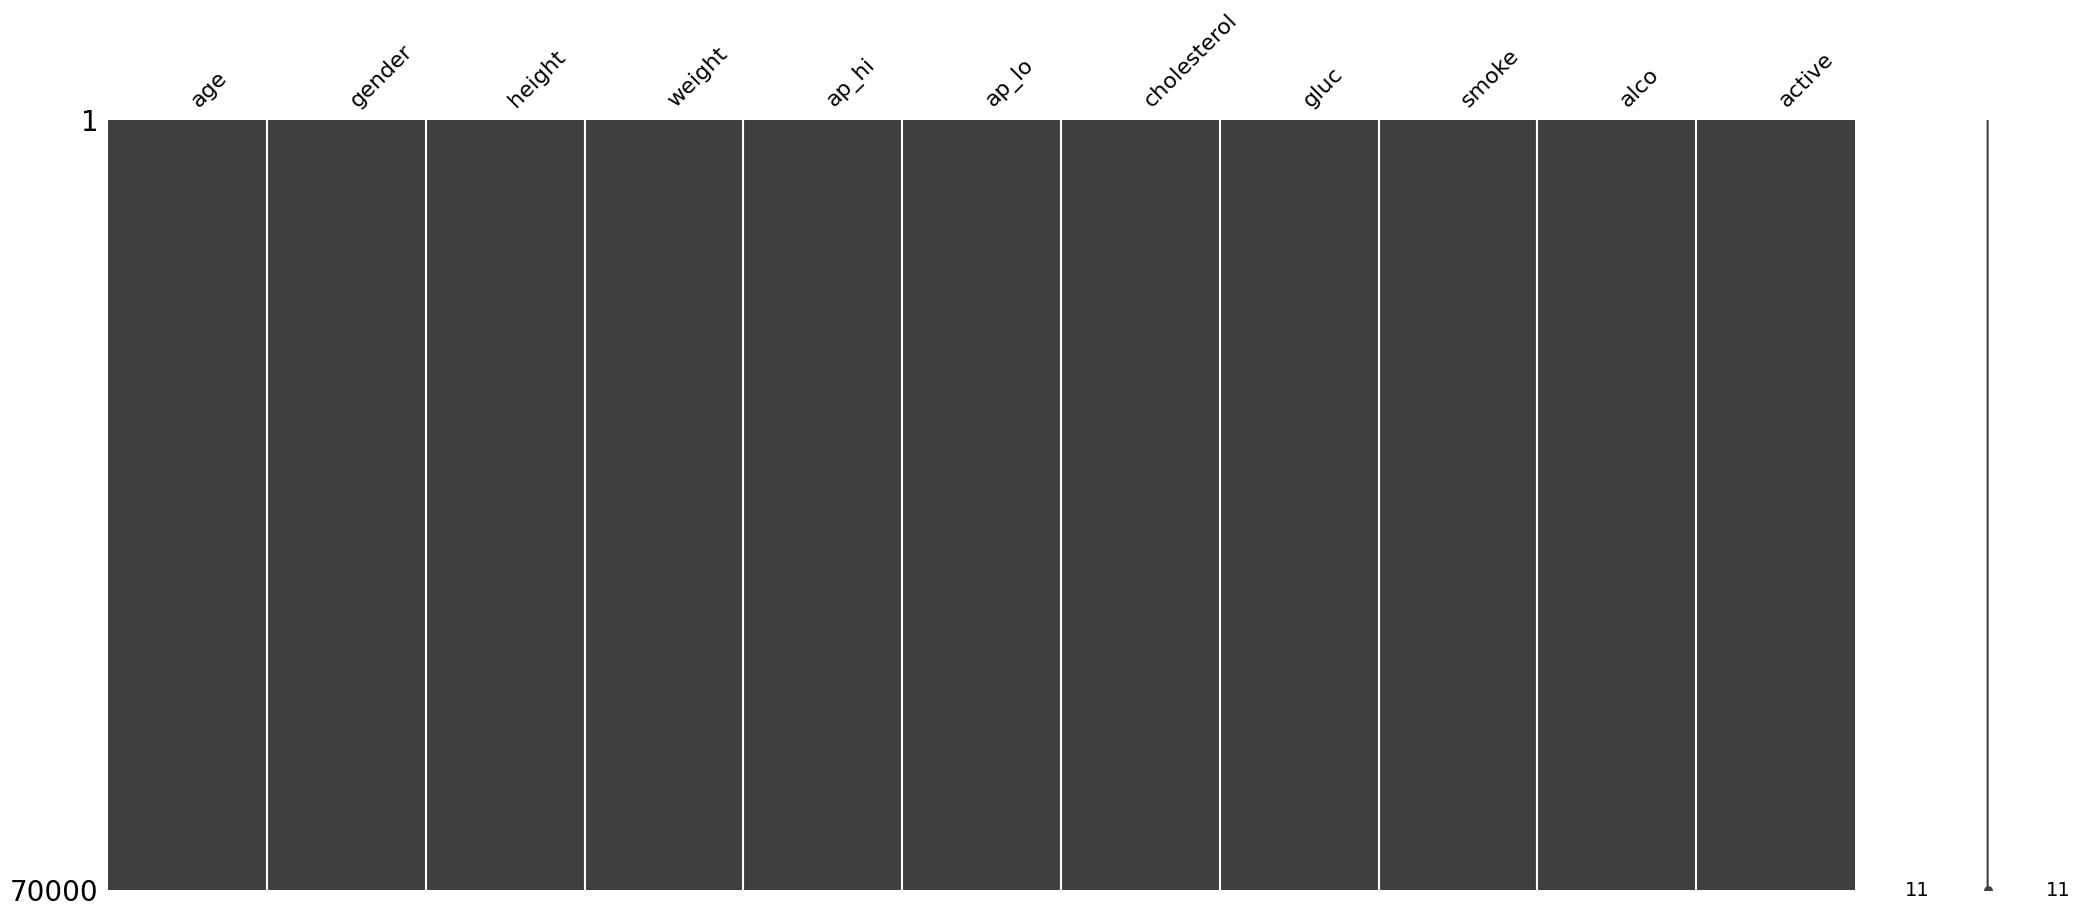

In [32]:
matrix(df)

Проверка датасета на наличие пропусков

In [33]:
binary_columns = df.columns[df.isin([0, 1]).all()]
df_check = df.drop(columns=binary_columns)

def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

print("Выбросы")
for column in df_check.columns:
    if pd.api.types.is_numeric_dtype(df_check[column]):
        outliers = detect_outliers(df_check[column])
        print(f"Количество выбросов в столбце '{column}': {outliers.sum()} ({round((outliers.sum() / df_check[column].size), 2)})")

Выбросы
Количество выбросов в столбце 'age': 4 (0.0)
Количество выбросов в столбце 'gender': 0 (0.0)
Количество выбросов в столбце 'height': 519 (0.01)
Количество выбросов в столбце 'weight': 1819 (0.03)
Количество выбросов в столбце 'ap_hi': 1435 (0.02)
Количество выбросов в столбце 'ap_lo': 4632 (0.07)
Количество выбросов в столбце 'cholesterol': 0 (0.0)
Количество выбросов в столбце 'gluc': 10521 (0.15)


Избавимся от выбросов с помощью метода межквартильного интервала

In [34]:
Q1 = df_check.quantile(0.25)
Q3 = df_check.quantile(0.75)

df = df.drop(columns=df_check)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

column_to_check = df_check[(df_check >= lower_bound) & (df_check <= upper_bound)]
df = pd.concat([column_to_check, df], axis=1)

Избавимся от пропусков в датасете

In [35]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df_filled_original = scaler.inverse_transform(df_filled)
df = pd.DataFrame(df_filled_original, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  float64
 2   height       70000 non-null  float64
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  float64
 5   ap_lo        70000 non-null  float64
 6   cholesterol  70000 non-null  float64
 7   gluc         70000 non-null  float64
 8   smoke        70000 non-null  float64
 9   alco         70000 non-null  float64
 10  active       70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


Выполним нормализацию и стандартизацию данных

In [36]:
standard_scaler = StandardScaler()

standard_data = standard_scaler.fit_transform(df)
df = pd.DataFrame(standard_data, columns=df.columns)

df.head()

age    gender    height    weight     ap_hi     ap_lo  cholesterol  \
0 -0.436404  1.364055  0.470154 -0.905921 -1.062436 -0.251989    -0.539322   
1  0.307601 -0.733108 -1.105485  0.953922  0.889390  1.029498     2.400793   
2 -0.248274 -0.733108  0.076244 -0.744196  0.238781 -1.533476     2.400793   
3 -0.748603  1.364055  0.601457  0.711334  1.539999  2.310984    -0.539322   
4 -0.809015 -0.733108 -1.105485 -1.391098 -1.713045 -1.097770    -0.539322   

   gluc     smoke      alco    active  
0   0.0 -0.310879 -0.238384  0.494167  
1   0.0 -0.310879 -0.238384  0.494167  
2   0.0 -0.310879 -0.238384 -2.023607  
3   0.0 -0.310879 -0.238384  0.494167  
4   0.0 -0.310879 -0.238384 -2.023607

Проверка баланса данных

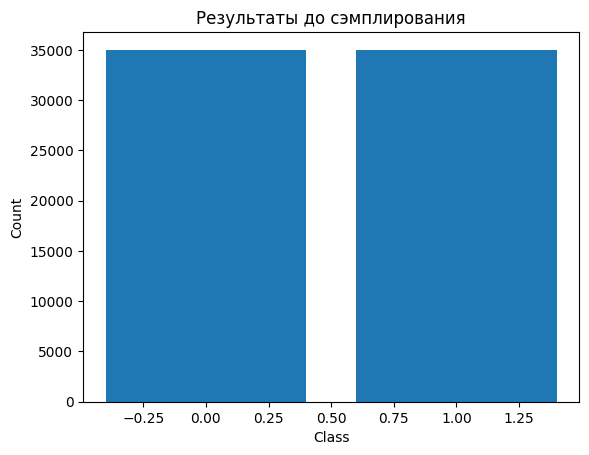

In [37]:
counter = Counter(target_data)
for k,v in counter.items():
    per = v / len(target_data) * 100
plt.bar(counter.keys(), counter.values())
plt.title("Результаты до сэмплирования")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


Подготовка данных для обучения

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df, target_data, test_size=0.3)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

XGBoost

In [45]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 1.0, log=True),
        "eval_metric": "logloss",
        "random_state": 42,
    }

    model = XGBClassifier(**params)

    scores = cross_validate(
        model, X_train, y_train,
        cv=stratified_kfold,
        scoring=['accuracy', 'f1', 'roc_auc', 'recall', 'precision']
    )

    f1_mean = np.mean(scores['test_f1'])
    return f1_mean

In [46]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_model = XGBClassifier(**study.best_params, eval_metric="logloss", random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\nМетрики на тесте:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")

cv_results = cross_validate(
    best_model, X_train, y_train,
    cv=stratified_kfold,
    scoring=['accuracy', 'f1', 'roc_auc', 'recall', 'precision']
)

print("\nСредние метрики на кросс-валидации:")
for metric_name, values in cv_results.items():
    if metric_name.startswith("test_"):
        print(f"{metric_name[5:]}: {np.mean(values):.4f}")

[I 2025-10-27 15:44:55,293] A new study created in memory with name: no-name-a53528d6-c955-4a23-befb-077c7bd993d9
Best trial: 0. Best value: 0.722338:   5%|████████▍                                                                                                                                                                | 1/20 [00:00<00:12,  1.47it/s]

[I 2025-10-27 15:44:55,970] Trial 0 finished with value: 0.7223384020389999 and parameters: {'n_estimators': 98, 'max_depth': 8, 'learning_rate': 0.10980986530305595, 'subsample': 0.849425652629397, 'colsample_bytree': 0.8770671735540339, 'gamma': 4.909602968039743, 'reg_alpha': 0.1580011569126893, 'reg_lambda': 0.15606210423366496}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  10%|████████████████▉                                                                                                                                                        | 2/20 [00:02<00:26,  1.46s/it]

[I 2025-10-27 15:44:57,980] Trial 1 finished with value: 0.7198816203195365 and parameters: {'n_estimators': 378, 'max_depth': 7, 'learning_rate': 0.11212806534590944, 'subsample': 0.9475872719626908, 'colsample_bytree': 0.8911893315638502, 'gamma': 0.9128069054823096, 'reg_alpha': 0.006085539490922956, 'reg_lambda': 0.00010835161520715687}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  15%|█████████████████████████▎                                                                                                                                               | 3/20 [00:04<00:29,  1.72s/it]

[I 2025-10-27 15:45:00,000] Trial 2 finished with value: 0.7196778519103784 and parameters: {'n_estimators': 396, 'max_depth': 8, 'learning_rate': 0.20169462762387572, 'subsample': 0.7859794210160986, 'colsample_bytree': 0.8809824115501708, 'gamma': 2.3151474789372957, 'reg_alpha': 2.152708470605036e-05, 'reg_lambda': 0.0009259528208883935}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  20%|█████████████████████████████████▊                                                                                                                                       | 4/20 [00:05<00:21,  1.36s/it]

[I 2025-10-27 15:45:00,820] Trial 3 finished with value: 0.7027014104288711 and parameters: {'n_estimators': 154, 'max_depth': 2, 'learning_rate': 0.01333359416722963, 'subsample': 0.9912177553204302, 'colsample_bytree': 0.9400467182462207, 'gamma': 0.8123109669033918, 'reg_alpha': 0.0001964487767458796, 'reg_lambda': 0.13444487543174174}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  25%|██████████████████████████████████████████▎                                                                                                                              | 5/20 [00:06<00:19,  1.33s/it]

[I 2025-10-27 15:45:02,086] Trial 4 finished with value: 0.7212369229055123 and parameters: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.06319697137478741, 'subsample': 0.7645538234972613, 'colsample_bytree': 0.9463908172443343, 'gamma': 4.288369649599952, 'reg_alpha': 0.11446838881494595, 'reg_lambda': 2.8914016477021314e-05}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  30%|██████████████████████████████████████████████████▋                                                                                                                      | 6/20 [00:08<00:22,  1.61s/it]

[I 2025-10-27 15:45:04,241] Trial 5 finished with value: 0.7218525523619694 and parameters: {'n_estimators': 483, 'max_depth': 4, 'learning_rate': 0.05079482065650646, 'subsample': 0.9448271615747388, 'colsample_bytree': 0.6632353900134599, 'gamma': 2.8910650110886875, 'reg_alpha': 0.0060739273072861364, 'reg_lambda': 0.006077794781216982}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  35%|███████████████████████████████████████████████████████████▏                                                                                                             | 7/20 [00:10<00:20,  1.57s/it]

[I 2025-10-27 15:45:05,733] Trial 6 finished with value: 0.7204180562712008 and parameters: {'n_estimators': 171, 'max_depth': 6, 'learning_rate': 0.018061679146864573, 'subsample': 0.7446491284465625, 'colsample_bytree': 0.8883923571078641, 'gamma': 3.8641670197862874, 'reg_alpha': 0.00012344235030486444, 'reg_lambda': 2.0438358197782477e-05}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 8/20 [00:10<00:14,  1.24s/it]

[I 2025-10-27 15:45:06,277] Trial 7 finished with value: 0.7193353486135918 and parameters: {'n_estimators': 74, 'max_depth': 3, 'learning_rate': 0.057418221980950104, 'subsample': 0.6824563582101096, 'colsample_bytree': 0.9302192737979034, 'gamma': 1.1864249788655667, 'reg_alpha': 0.002120144012224666, 'reg_lambda': 0.8304352723694692}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 9/20 [00:12<00:13,  1.27s/it]

[I 2025-10-27 15:45:07,595] Trial 8 finished with value: 0.7165360166140575 and parameters: {'n_estimators': 163, 'max_depth': 6, 'learning_rate': 0.22207077012181373, 'subsample': 0.7068392532748036, 'colsample_bytree': 0.895501908783988, 'gamma': 0.6680156806772741, 'reg_alpha': 0.0010929071775550635, 'reg_lambda': 0.9910671834030385}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10/20 [00:12<00:10,  1.08s/it]

[I 2025-10-27 15:45:08,255] Trial 9 finished with value: 0.7193515321762761 and parameters: {'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.044236446391586956, 'subsample': 0.6509562096542444, 'colsample_bytree': 0.9564959385799052, 'gamma': 3.077006384252039, 'reg_alpha': 0.0007029122367110934, 'reg_lambda': 0.00010582152650656217}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11/20 [00:14<00:10,  1.20s/it]

[I 2025-10-27 15:45:09,716] Trial 10 finished with value: 0.7219283327368724 and parameters: {'n_estimators': 283, 'max_depth': 10, 'learning_rate': 0.11501361413934715, 'subsample': 0.5730939884752005, 'colsample_bytree': 0.505428678228203, 'gamma': 4.948177624445407, 'reg_alpha': 0.8834256433222404, 'reg_lambda': 0.025299396946034274}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 0. Best value: 0.722338:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12/20 [00:15<00:10,  1.25s/it]

[I 2025-10-27 15:45:11,095] Trial 11 finished with value: 0.7217658266995897 and parameters: {'n_estimators': 284, 'max_depth': 10, 'learning_rate': 0.124190088777296, 'subsample': 0.5042809173387266, 'colsample_bytree': 0.5147483951123255, 'gamma': 4.984836491666639, 'reg_alpha': 0.4970673045838336, 'reg_lambda': 0.025915738485805775}. Best is trial 0 with value: 0.7223384020389999.


Best trial: 12. Best value: 0.722371:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:17<00:09,  1.29s/it]

[I 2025-10-27 15:45:12,459] Trial 12 finished with value: 0.722371058521415 and parameters: {'n_estimators': 272, 'max_depth': 10, 'learning_rate': 0.10997771241385033, 'subsample': 0.8407703703799031, 'colsample_bytree': 0.7677549680785936, 'gamma': 4.831051566111503, 'reg_alpha': 0.8221345333084491, 'reg_lambda': 0.06578793535027758}. Best is trial 12 with value: 0.722371058521415.


Best trial: 12. Best value: 0.722371:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:18<00:08,  1.43s/it]

[I 2025-10-27 15:45:14,238] Trial 13 finished with value: 0.7220977091421723 and parameters: {'n_estimators': 205, 'max_depth': 9, 'learning_rate': 0.023392391650967854, 'subsample': 0.8471464600847525, 'colsample_bytree': 0.7732522510195938, 'gamma': 3.9172572439685083, 'reg_alpha': 0.0637133498095203, 'reg_lambda': 0.14096042484553173}. Best is trial 12 with value: 0.722371058521415.


Best trial: 12. Best value: 0.722371:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:21<00:08,  1.65s/it]

[I 2025-10-27 15:45:16,401] Trial 14 finished with value: 0.7217345047438999 and parameters: {'n_estimators': 360, 'max_depth': 8, 'learning_rate': 0.08245986343147822, 'subsample': 0.8705663671630572, 'colsample_bytree': 0.7812069887310639, 'gamma': 2.110261877530519, 'reg_alpha': 0.04332167031643521, 'reg_lambda': 0.10738138566149164}. Best is trial 12 with value: 0.722371058521415.


Best trial: 15. Best value: 0.722413:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:21<00:05,  1.31s/it]

[I 2025-10-27 15:45:16,909] Trial 15 finished with value: 0.7224125351710304 and parameters: {'n_estimators': 51, 'max_depth': 9, 'learning_rate': 0.28039111652956544, 'subsample': 0.8577466653925646, 'colsample_bytree': 0.6986068272197385, 'gamma': 4.4397613325719245, 'reg_alpha': 0.269389748779241, 'reg_lambda': 0.0038862695792816863}. Best is trial 15 with value: 0.7224125351710304.


Best trial: 15. Best value: 0.722413:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [00:23<00:04,  1.41s/it]

[I 2025-10-27 15:45:18,538] Trial 16 finished with value: 0.7215552244030206 and parameters: {'n_estimators': 336, 'max_depth': 10, 'learning_rate': 0.2903225427328509, 'subsample': 0.8055939107775545, 'colsample_bytree': 0.6821951677984709, 'gamma': 4.1420567812661435, 'reg_alpha': 0.015397490571486169, 'reg_lambda': 0.00181678351818902}. Best is trial 15 with value: 0.7224125351710304.


Best trial: 15. Best value: 0.722413:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [00:25<00:03,  1.59s/it]

[I 2025-10-27 15:45:20,549] Trial 17 finished with value: 0.7220187376188754 and parameters: {'n_estimators': 448, 'max_depth': 9, 'learning_rate': 0.18185303005052963, 'subsample': 0.8940122895617444, 'colsample_bytree': 0.7028602810725997, 'gamma': 3.438161138909625, 'reg_alpha': 0.3349739838904484, 'reg_lambda': 0.007586668978293248}. Best is trial 15 with value: 0.7224125351710304.


Best trial: 15. Best value: 0.722413:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [00:26<00:01,  1.57s/it]

[I 2025-10-27 15:45:22,079] Trial 18 finished with value: 0.721914681155782 and parameters: {'n_estimators': 117, 'max_depth': 9, 'learning_rate': 0.03318500603988697, 'subsample': 0.9243722883897288, 'colsample_bytree': 0.6119012470685568, 'gamma': 1.7136397030269008, 'reg_alpha': 0.023569395586185225, 'reg_lambda': 0.0005223793937862842}. Best is trial 15 with value: 0.7224125351710304.


Best trial: 15. Best value: 0.722413: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


[I 2025-10-27 15:45:23,205] Trial 19 finished with value: 0.7214481497932255 and parameters: {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.29794139767190636, 'subsample': 0.8227099691293128, 'colsample_bytree': 0.8045374480781463, 'gamma': 4.480186182995403, 'reg_alpha': 0.21760483753542526, 'reg_lambda': 0.020713589024004105}. Best is trial 15 with value: 0.7224125351710304.
Лучшие гиперпараметры:
  n_estimators: 51
  max_depth: 9
  learning_rate: 0.28039111652956544
  subsample: 0.8577466653925646
  colsample_bytree: 0.6986068272197385
  gamma: 4.4397613325719245
  reg_alpha: 0.269389748779241
  reg_lambda: 0.0038862695792816863

Метрики на тесте:
Accuracy:  0.7281
F1 Score:  0.7196
ROC AUC:   0.7966
Recall:    0.6885
Precision: 0.7536

Средние метрики на кросс-валидации:
accuracy: 0.7353
f1: 0.7224
roc_auc: 0.7989
recall: 0.6934
precision: 0.7540


LightGBM

In [47]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 1.0, log=True),
        "random_state": 42,
    }

    model = LGBMClassifier(**params)

    scores = cross_validate(
        model, X_train, y_train,
        cv=stratified_kfold,
        scoring=['accuracy', 'f1', 'roc_auc', 'recall', 'precision']
    )

    f1_mean = np.mean(scores['test_f1'])
    return f1_mean

In [48]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_model = LGBMClassifier(**study.best_params, objective="binary", random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\n Метрики на тесте:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")

cv_results = cross_validate(
    best_model, X_train, y_train,
    cv=stratified_kfold,
    scoring=['accuracy', 'f1', 'roc_auc', 'recall', 'precision'],
    n_jobs=-1
)

print("\n Средние метрики на кросс-валидации:")
for metric_name, values in cv_results.items():
    if metric_name.startswith("test_"):
        print(f"{metric_name[5:]}: {np.mean(values):.4f}")

[I 2025-10-27 15:59:49,397] A new study created in memory with name: no-name-034bc434-1ccf-4d51-a333-14f24e3cef48
  0%|                                                                                                                                                                                                                      | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Best trial: 0. Best value: 0.718098:   5%|████████▍                                                                                                                                                                | 1/20 [00:08<02:40,  8.47s/it]

[I 2025-10-27 15:59:57,863] Trial 0 finished with value: 0.7180981797152323 and parameters: {'n_estimators': 290, 'learning_rate': 0.05817491978279312, 'num_leaves': 193, 'max_depth': 12, 'min_child_samples': 77, 'subsample': 0.772805451211376, 'colsample_bytree': 0.9191541478643654, 'reg_alpha': 0.6139375994162536, 'reg_lambda': 0.05072840679854099}. Best is trial 0 with value: 0.7180981797152323.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Info] Number of positive: 194

Best trial: 1. Best value: 0.722014:  10%|████████████████▉                                                                                                                                                        | 2/20 [00:11<01:33,  5.21s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-10-27 16:00:00,788] Trial 1 finished with value: 0.7220140375227193 and parameters: {'n_estimators': 269, 'learning_rate': 0.015377285461188325, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 62, 'subsample': 0.6434074782710536, 'colsample_bytree': 0.5874316101789363, 'reg_alpha': 0.0011831417938530679, 'reg_lambda': 0.147132612356107}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] 

Best trial: 1. Best value: 0.722014:  15%|█████████████████████████▎                                                                                                                                               | 3/20 [00:17<01:38,  5.82s/it]

[I 2025-10-27 16:00:07,341] Trial 2 finished with value: 0.718318784881807 and parameters: {'n_estimators': 537, 'learning_rate': 0.04981893338105336, 'num_leaves': 107, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.8062918580530984, 'colsample_bytree': 0.5227117937450413, 'reg_alpha': 0.0005887360329832836, 'reg_lambda': 0.012878550375078436}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits

Best trial: 1. Best value: 0.722014:  20%|█████████████████████████████████▊                                                                                                                                       | 4/20 [00:32<02:31,  9.45s/it]

[I 2025-10-27 16:00:22,343] Trial 3 finished with value: 0.7203647026571991 and parameters: {'n_estimators': 803, 'learning_rate': 0.01366768428693886, 'num_leaves': 239, 'max_depth': 10, 'min_child_samples': 71, 'subsample': 0.9036166984098768, 'colsample_bytree': 0.6275554628706297, 'reg_alpha': 0.002035863298516778, 'reg_lambda': 0.5656762031417506}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits 

Best trial: 1. Best value: 0.722014:  25%|██████████████████████████████████████████▎                                                                                                                              | 5/20 [00:36<01:50,  7.38s/it]

[I 2025-10-27 16:00:26,071] Trial 4 finished with value: 0.717362749405185 and parameters: {'n_estimators': 609, 'learning_rate': 0.14356402461436626, 'num_leaves': 133, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.8011939730861111, 'colsample_bytree': 0.7347156073156145, 'reg_alpha': 0.005505751387395145, 'reg_lambda': 8.235470043678367e-05}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits

Best trial: 1. Best value: 0.722014:  30%|██████████████████████████████████████████████████▋                                                                                                                      | 6/20 [00:37<01:13,  5.27s/it]

[I 2025-10-27 16:00:27,243] Trial 5 finished with value: 0.7212274803123563 and parameters: {'n_estimators': 186, 'learning_rate': 0.05987003800947315, 'num_leaves': 242, 'max_depth': 4, 'min_child_samples': 98, 'subsample': 0.6707163956139742, 'colsample_bytree': 0.534657823712541, 'reg_alpha': 0.0022760678226929096, 'reg_lambda': 0.0009439418353272191}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further split

Best trial: 1. Best value: 0.722014:  35%|███████████████████████████████████████████████████████████▏                                                                                                             | 7/20 [00:44<01:14,  5.76s/it]

[I 2025-10-27 16:00:33,991] Trial 6 finished with value: 0.7190163156517118 and parameters: {'n_estimators': 378, 'learning_rate': 0.03386409852874698, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 33, 'subsample': 0.9282553460690847, 'colsample_bytree': 0.7190798586061233, 'reg_alpha': 1.402722420990466e-05, 'reg_lambda': 0.13076183773566658}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further split

Best trial: 1. Best value: 0.722014:  40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 8/20 [00:47<00:57,  4.75s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 0.722014:  45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 9/20 [00:52<00:53,  4.86s/it]

[I 2025-10-27 16:00:41,705] Trial 8 finished with value: 0.7137500841553833 and parameters: {'n_estimators': 425, 'learning_rate': 0.11656015998154814, 'num_leaves': 255, 'max_depth': 8, 'min_child_samples': 44, 'subsample': 0.6625751116061083, 'colsample_bytree': 0.6433212767869798, 'reg_alpha': 0.9712845105816652, 'reg_lambda': 0.003379551643333647}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Info] Number of positive: 19

Best trial: 1. Best value: 0.722014:  50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10/20 [00:54<00:40,  4.01s/it]

[I 2025-10-27 16:00:43,798] Trial 9 finished with value: 0.7191318811623374 and parameters: {'n_estimators': 204, 'learning_rate': 0.007370355632917929, 'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 94, 'subsample': 0.7432172810386477, 'colsample_bytree': 0.792777027686699, 'reg_alpha': 0.8034372177206286, 'reg_lambda': 0.030842517721946103}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits w

Best trial: 1. Best value: 0.722014:  55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11/20 [01:06<00:59,  6.63s/it]

[I 2025-10-27 16:00:56,389] Trial 10 finished with value: 0.7210279216321833 and parameters: {'n_estimators': 950, 'learning_rate': 0.01982301208908357, 'num_leaves': 78, 'max_depth': 9, 'min_child_samples': 58, 'subsample': 0.5388608937292528, 'colsample_bytree': 0.8397265837968857, 'reg_alpha': 0.00016510027670899572, 'reg_lambda': 0.6191522586764225}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits

Best trial: 1. Best value: 0.722014:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12/20 [01:08<00:41,  5.13s/it]

[I 2025-10-27 16:00:58,067] Trial 11 finished with value: 0.716127953290598 and parameters: {'n_estimators': 101, 'learning_rate': 0.025784356767788653, 'num_leaves': 194, 'max_depth': 6, 'min_child_samples': 100, 'subsample': 0.5724614998268549, 'colsample_bytree': 0.5120274711509537, 'reg_alpha': 0.0191738881715551, 'reg_lambda': 0.0007781121734786974}. Best is trial 1 with value: 0.7220140375227193.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further split

Best trial: 12. Best value: 0.722131:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [01:09<00:27,  3.88s/it]

[I 2025-10-27 16:00:59,087] Trial 12 finished with value: 0.7221314402840429 and parameters: {'n_estimators': 112, 'learning_rate': 0.24539100698817035, 'num_leaves': 68, 'max_depth': 3, 'min_child_samples': 82, 'subsample': 0.6667551122233745, 'colsample_bytree': 0.5916362023892874, 'reg_alpha': 0.042586720822331885, 'reg_lambda': 1.6047252364751425e-05}. Best is trial 12 with value: 0.7221314402840429.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further spl

Best trial: 12. Best value: 0.722131:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [01:12<00:21,  3.65s/it]

[I 2025-10-27 16:01:02,199] Trial 13 finished with value: 0.7147939998196182 and parameters: {'n_estimators': 264, 'learning_rate': 0.279542034168024, 'num_leaves': 66, 'max_depth': 6, 'min_child_samples': 76, 'subsample': 0.6047747563426001, 'colsample_bytree': 0.5916126211005213, 'reg_alpha': 0.03208976723663987, 'reg_lambda': 1.378386018082888e-05}. Best is trial 12 with value: 0.7221314402840429.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits 

Best trial: 12. Best value: 0.722131:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [01:13<00:21,  3.65s/it]

[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Best trial: 14. Best value: 0.722453:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [01:13<00:14,  2.89s/it]

[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Best trial: 15. Best value: 0.722875:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [01:15<00:09,  2.39s/it]

[I 2025-10-27 16:01:04,565] Trial 15 finished with value: 0.7228753203949787 and parameters: {'n_estimators': 131, 'learning_rate': 0.288856062667344, 'num_leaves': 95, 'max_depth': 3, 'min_child_samples': 47, 'subsample': 0.718365729477274, 'colsample_bytree': 0.9963619476466492, 'reg_alpha': 0.08831474775893336, 'reg_lambda': 1.0706429406862583e-05}. Best is trial 15 with value: 0.7228753203949787.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

Best trial: 15. Best value: 0.722875:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [01:20<00:09,  3.16s/it]

[I 2025-10-27 16:01:09,490] Trial 16 finished with value: 0.7202029463385584 and parameters: {'n_estimators': 675, 'learning_rate': 0.13094994151329076, 'num_leaves': 20, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.5092583802043008, 'colsample_bytree': 0.9922113287927146, 'reg_alpha': 0.12722937947770088, 'reg_lambda': 6.077767652210624e-05}. Best is trial 15 with value: 0.7228753203949787.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further split

Best trial: 15. Best value: 0.722875:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [01:24<00:06,  3.42s/it]

[I 2025-10-27 16:01:13,533] Trial 17 finished with value: 0.7142705582952334 and parameters: {'n_estimators': 349, 'learning_rate': 0.18871676613280733, 'num_leaves': 104, 'max_depth': 6, 'min_child_samples': 35, 'subsample': 0.8638883966113541, 'colsample_bytree': 0.8752594083885326, 'reg_alpha': 0.20220259635559612, 'reg_lambda': 5.111690509058893e-05}. Best is trial 15 with value: 0.7228753203949787.
[LightGBM] [Info] Number of positive: 19472, number of negative: 19728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 39200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496735 -> initscore=-0.013061
[LightGBM] [Info] Start training from score -0.013061
[LightGBM] [Warning] No further spli

Best trial: 15. Best value: 0.722875:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [01:25<00:02,  2.81s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 15. Best value: 0.722875: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.44s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

CatBoost

In [49]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "eval_metric": "F1",
        "loss_function": "Logloss",
        "random_seed": 42
    }

    model = CatBoostClassifier(**params)

    scores = cross_validate(
        model, X_train, y_train,
        cv=stratified_kfold,
        scoring=['accuracy', 'f1', 'roc_auc', 'recall', 'precision'],
    )

    f1_mean = np.mean(scores['test_f1'])
    return f1_mean

In [51]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

print("\nЛучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_model = CatBoostClassifier(
    **study.best_params,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=42,
    verbose=100
)

best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\n Метрики на тестовой выборке:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")

cv_results = cross_validate(
    best_model, X_train, y_train,
    cv=stratified_kfold,
    scoring=['accuracy', 'f1', 'roc_auc', 'recall', 'precision']
)

print("\n Средние метрики на кросс-валидации:")
for metric_name, values in cv_results.items():
    if metric_name.startswith("test_"):
        print(f"{metric_name[5:]}: {np.mean(values):.4f}")

[I 2025-10-27 16:14:06,312] A new study created in memory with name: no-name-f9225b3e-7b6f-40b7-a9ba-ce6a17f5d845
  0%|                                                                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

0:	learn: 0.7071040	total: 8.53ms	remaining: 4.91s
1:	learn: 0.7063348	total: 14.7ms	remaining: 4.22s
2:	learn: 0.7066721	total: 20.6ms	remaining: 3.94s
3:	learn: 0.7065035	total: 26.5ms	remaining: 3.8s
4:	learn: 0.7067230	total: 33.4ms	remaining: 3.83s
5:	learn: 0.7063892	total: 38.9ms	remaining: 3.7s
6:	learn: 0.7067201	total: 44.6ms	remaining: 3.63s
7:	learn: 0.7066598	total: 50.1ms	remaining: 3.56s
8:	learn: 0.7071369	total: 55.5ms	remaining: 3.5s
9:	learn: 0.7071889	total: 60.7ms	remaining: 3.44s
10:	learn: 0.7063270	total: 66.2ms	remaining: 3.4s
11:	learn: 0.7066340	total: 72.2ms	remaining: 3.4s
12:	learn: 0.7079459	total: 77.5ms	remaining: 3.36s
13:	learn: 0.7069232	total: 83.4ms	remaining: 3.35s
14:	learn: 0.7084225	total: 88.7ms	remaining: 3.32s
15:	learn: 0.7086461	total: 94.3ms	remaining: 3.31s
16:	learn: 0.7082271	total: 101ms	remaining: 3.33s
17:	learn: 0.7087729	total: 108ms	remaining: 3.34s
18:	learn: 0.7088318	total: 113ms	remaining: 3.33s
19:	learn: 0.7113319	total: 11

Best trial: 0. Best value: 0.723318:  10%|████████████████▉                                                                                                                                                        | 1/10 [00:20<03:06, 20.78s/it]

[I 2025-10-27 16:14:27,088] Trial 0 finished with value: 0.7233181382435846 and parameters: {'iterations': 577, 'depth': 4, 'learning_rate': 0.06863193772114466, 'l2_leaf_reg': 0.027923072287545495, 'border_count': 33, 'bagging_temperature': 0.12183387702522486, 'random_strength': 0.29754347054694197, 'subsample': 0.5583871905705275}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.7230821	total: 8.05ms	remaining: 6.64s
1:	learn: 0.7200443	total: 16.4ms	remaining: 6.78s
2:	learn: 0.7200253	total: 24.3ms	remaining: 6.67s
3:	learn: 0.7193540	total: 32.8ms	remaining: 6.74s
4:	learn: 0.7184166	total: 40.4ms	remaining: 6.64s
5:	learn: 0.7183908	total: 47.7ms	remaining: 6.51s
6:	learn: 0.7188561	total: 55.1ms	remaining: 6.44s
7:	learn: 0.7188544	total: 62.5ms	remaining: 6.39s
8:	learn: 0.7197776	total: 71.3ms	remaining: 6.47s
9:	learn: 0.7203237	total: 78.6ms	remaining: 6.42s
10:	learn: 0.7193388	total: 85.8ms	remaining: 6.36s
11:	learn: 0.7195475	total: 93.1ms	remaining: 6.31s
1

Best trial: 0. Best value: 0.723318:  20%|█████████████████████████████████▊                                                                                                                                       | 2/10 [01:01<04:19, 32.45s/it]

821:	learn: 0.7493408	total: 8.27s	remaining: 40.2ms
822:	learn: 0.7493408	total: 8.28s	remaining: 30.2ms
823:	learn: 0.7493873	total: 8.29s	remaining: 20.1ms
824:	learn: 0.7494406	total: 8.3s	remaining: 10.1ms
825:	learn: 0.7495471	total: 8.31s	remaining: 0us
[I 2025-10-27 16:15:07,714] Trial 1 finished with value: 0.721967114358106 and parameters: {'iterations': 826, 'depth': 6, 'learning_rate': 0.038525885212589525, 'l2_leaf_reg': 0.011786825057877148, 'border_count': 66, 'bagging_temperature': 0.9626046688885963, 'random_strength': 0.06998251280689638, 'subsample': 0.7918252666209298}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.7206698	total: 8.22ms	remaining: 1.89s
1:	learn: 0.7192042	total: 17.2ms	remaining: 1.96s
2:	learn: 0.7204670	total: 25.5ms	remaining: 1.94s
3:	learn: 0.7204670	total: 33.6ms	remaining: 1.91s
4:	learn: 0.7204670	total: 42.4ms	remaining: 1.92s
5:	learn: 0.7204670	total: 51ms	remaining: 1.91s
6:	learn: 0.7204670	total: 59.4ms	remaining: 1.9s
7

Best trial: 0. Best value: 0.723318:  30%|██████████████████████████████████████████████████▋                                                                                                                      | 3/10 [01:14<02:44, 23.48s/it]

225:	learn: 0.7261727	total: 2.43s	remaining: 53.8ms
226:	learn: 0.7261435	total: 2.44s	remaining: 43ms
227:	learn: 0.7261921	total: 2.45s	remaining: 32.3ms
228:	learn: 0.7262019	total: 2.46s	remaining: 21.5ms
229:	learn: 0.7263085	total: 2.47s	remaining: 10.8ms
230:	learn: 0.7261873	total: 2.48s	remaining: 0us
[I 2025-10-27 16:15:20,516] Trial 2 finished with value: 0.7198829800376914 and parameters: {'iterations': 231, 'depth': 7, 'learning_rate': 0.007296133818374698, 'l2_leaf_reg': 0.025753403527571807, 'border_count': 121, 'bagging_temperature': 0.9778308141103867, 'random_strength': 0.032329507163081694, 'subsample': 0.9310119811226609}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.6934948	total: 7.09ms	remaining: 6.64s
1:	learn: 0.7062587	total: 15.1ms	remaining: 7.07s
2:	learn: 0.7059499	total: 22.4ms	remaining: 6.96s
3:	learn: 0.7067599	total: 30.1ms	remaining: 7.01s
4:	learn: 0.7100187	total: 38.7ms	remaining: 7.22s
5:	learn: 0.7111328	total: 46.8ms	remaining: 

Best trial: 0. Best value: 0.723318:  40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 4/10 [01:59<03:13, 32.19s/it]

[I 2025-10-27 16:16:06,059] Trial 3 finished with value: 0.7230567823472881 and parameters: {'iterations': 937, 'depth': 6, 'learning_rate': 0.02250543535247675, 'l2_leaf_reg': 0.006656148861894727, 'border_count': 34, 'bagging_temperature': 0.9086359696138804, 'random_strength': 0.13295443652871752, 'subsample': 0.5826348066458299}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.6810109	total: 8.05ms	remaining: 6.92s
1:	learn: 0.6813795	total: 20.6ms	remaining: 8.86s
2:	learn: 0.6813795	total: 33.8ms	remaining: 9.66s
3:	learn: 0.6813795	total: 47.6ms	remaining: 10.2s
4:	learn: 0.6812883	total: 65.9ms	remaining: 11.3s
5:	learn: 0.6812343	total: 74.9ms	remaining: 10.7s
6:	learn: 0.6809568	total: 91.1ms	remaining: 11.1s
7:	learn: 0.6809568	total: 101ms	remaining: 10.8s
8:	learn: 0.6809941	total: 110ms	remaining: 10.4s
9:	learn: 0.6809100	total: 119ms	remaining: 10.1s
10:	learn: 0.6810686	total: 127ms	remaining: 9.78s
11:	learn: 0.6813932	total: 133ms	remaining: 9.4s
12:	lear

Best trial: 0. Best value: 0.723318:  50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 5/10 [02:30<02:37, 31.60s/it]

[I 2025-10-27 16:16:36,604] Trial 4 finished with value: 0.7200267762076653 and parameters: {'iterations': 861, 'depth': 3, 'learning_rate': 0.008470096293610674, 'l2_leaf_reg': 0.0040567258624325175, 'border_count': 74, 'bagging_temperature': 0.7615842449189646, 'random_strength': 0.23589944068620206, 'subsample': 0.840359254170216}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.7158654	total: 14ms	remaining: 9.78s
1:	learn: 0.7151072	total: 80ms	remaining: 28s
2:	learn: 0.7104568	total: 98.1ms	remaining: 22.8s
3:	learn: 0.7101054	total: 113ms	remaining: 19.7s
4:	learn: 0.7101481	total: 129ms	remaining: 17.9s
5:	learn: 0.7128469	total: 142ms	remaining: 16.4s
6:	learn: 0.7117369	total: 152ms	remaining: 15.1s
7:	learn: 0.7144026	total: 163ms	remaining: 14.2s
8:	learn: 0.7145543	total: 177ms	remaining: 13.6s
9:	learn: 0.7154118	total: 188ms	remaining: 13s
10:	learn: 0.7154741	total: 199ms	remaining: 12.5s
11:	learn: 0.7161978	total: 210ms	remaining: 12s
12:	learn: 0.7156153

Best trial: 0. Best value: 0.723318:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 6/10 [03:15<02:24, 36.25s/it]

[I 2025-10-27 16:17:21,882] Trial 5 finished with value: 0.719090329438647 and parameters: {'iterations': 701, 'depth': 8, 'learning_rate': 0.04905014272225829, 'l2_leaf_reg': 0.01053847251600751, 'border_count': 73, 'bagging_temperature': 0.8492726067101815, 'random_strength': 0.6379438597093626, 'subsample': 0.8062010224934908}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.7164251	total: 72.9ms	remaining: 1m
1:	learn: 0.7168596	total: 115ms	remaining: 48s
2:	learn: 0.7193991	total: 139ms	remaining: 38.5s
3:	learn: 0.7199935	total: 162ms	remaining: 33.7s
4:	learn: 0.7206972	total: 185ms	remaining: 30.7s
5:	learn: 0.7215635	total: 209ms	remaining: 28.8s
6:	learn: 0.7234146	total: 231ms	remaining: 27.3s
7:	learn: 0.7253221	total: 253ms	remaining: 26.1s
8:	learn: 0.7264014	total: 276ms	remaining: 25.3s
9:	learn: 0.7274587	total: 299ms	remaining: 24.6s
10:	learn: 0.7291443	total: 323ms	remaining: 24.2s
11:	learn: 0.7303937	total: 346ms	remaining: 23.7s
12:	learn: 0.7314273	

Best trial: 0. Best value: 0.723318:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 7/10 [05:04<02:59, 59.96s/it]

[I 2025-10-27 16:19:10,658] Trial 6 finished with value: 0.6934797431128796 and parameters: {'iterations': 834, 'depth': 10, 'learning_rate': 0.13237325796529203, 'l2_leaf_reg': 0.002979293967446566, 'border_count': 69, 'bagging_temperature': 0.6906819517827639, 'random_strength': 0.8004353345830681, 'subsample': 0.7213215730665884}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.6914894	total: 6.98ms	remaining: 3.16s
1:	learn: 0.7078043	total: 13.8ms	remaining: 3.12s
2:	learn: 0.7067444	total: 20.6ms	remaining: 3.1s
3:	learn: 0.7083593	total: 26.7ms	remaining: 3s
4:	learn: 0.7077432	total: 33.7ms	remaining: 3.03s
5:	learn: 0.7155792	total: 39.6ms	remaining: 2.96s
6:	learn: 0.7175613	total: 46.4ms	remaining: 2.96s
7:	learn: 0.7183403	total: 52.9ms	remaining: 2.95s
8:	learn: 0.7184777	total: 59.1ms	remaining: 2.92s
9:	learn: 0.7187525	total: 65.4ms	remaining: 2.9s
10:	learn: 0.7181728	total: 71.6ms	remaining: 2.88s
11:	learn: 0.7191095	total: 77.3ms	remaining: 2.85s
12:	lea

Best trial: 0. Best value: 0.723318:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8/10 [05:23<01:33, 46.91s/it]

448:	learn: 0.7446226	total: 3.83s	remaining: 42.7ms
449:	learn: 0.7446497	total: 3.84s	remaining: 34.1ms
450:	learn: 0.7444829	total: 3.85s	remaining: 25.6ms
451:	learn: 0.7444891	total: 3.86s	remaining: 17.1ms
452:	learn: 0.7444223	total: 3.87s	remaining: 8.54ms
453:	learn: 0.7443493	total: 3.88s	remaining: 0us
[I 2025-10-27 16:19:29,620] Trial 7 finished with value: 0.721799494354401 and parameters: {'iterations': 454, 'depth': 4, 'learning_rate': 0.20886265462921663, 'l2_leaf_reg': 2.1197451503141314, 'border_count': 120, 'bagging_temperature': 0.357841302361701, 'random_strength': 0.7964003742092103, 'subsample': 0.7450230863284925}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.6810854	total: 6.27ms	remaining: 3.39s
1:	learn: 0.6810481	total: 14.4ms	remaining: 3.88s
2:	learn: 0.6810481	total: 20.8ms	remaining: 3.74s
3:	learn: 0.6810481	total: 27.2ms	remaining: 3.66s
4:	learn: 0.6809941	total: 33.1ms	remaining: 3.56s
5:	learn: 0.6809941	total: 40.9ms	remaining: 3.65s

Best trial: 0. Best value: 0.723318:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9/10 [05:42<00:38, 38.33s/it]

532:	learn: 0.7228278	total: 3.7s	remaining: 62.5ms
533:	learn: 0.7227789	total: 3.71s	remaining: 55.6ms
534:	learn: 0.7228426	total: 3.72s	remaining: 48.6ms
535:	learn: 0.7228665	total: 3.72s	remaining: 41.7ms
536:	learn: 0.7229154	total: 3.73s	remaining: 34.8ms
537:	learn: 0.7228768	total: 3.74s	remaining: 27.8ms
538:	learn: 0.7229643	total: 3.75s	remaining: 20.9ms
539:	learn: 0.7229450	total: 3.76s	remaining: 13.9ms
540:	learn: 0.7229450	total: 3.76s	remaining: 6.96ms
541:	learn: 0.7229212	total: 3.77s	remaining: 0us
[I 2025-10-27 16:19:49,099] Trial 8 finished with value: 0.7193093332800291 and parameters: {'iterations': 542, 'depth': 3, 'learning_rate': 0.009926135243186689, 'l2_leaf_reg': 0.026203810685444143, 'border_count': 99, 'bagging_temperature': 0.6389991629047947, 'random_strength': 0.09806639006473694, 'subsample': 0.9236523990004861}. Best is trial 0 with value: 0.7233181382435846.
0:	learn: 0.7071040	total: 6.52ms	remaining: 1.62s
1:	learn: 0.7067547	total: 13.4ms	rema

Best trial: 0. Best value: 0.723318: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:54<00:00, 35.41s/it]

236:	learn: 0.7273307	total: 2.07s	remaining: 105ms
237:	learn: 0.7272776	total: 2.08s	remaining: 96.2ms
238:	learn: 0.7274563	total: 2.09s	remaining: 87.4ms
239:	learn: 0.7274902	total: 2.1s	remaining: 78.7ms
240:	learn: 0.7273597	total: 2.1s	remaining: 69.9ms
241:	learn: 0.7273017	total: 2.11s	remaining: 61.1ms
242:	learn: 0.7273500	total: 2.12s	remaining: 52.3ms
243:	learn: 0.7273500	total: 2.13s	remaining: 43.6ms
244:	learn: 0.7273935	total: 2.13s	remaining: 34.9ms
245:	learn: 0.7273935	total: 2.14s	remaining: 26.1ms
246:	learn: 0.7275191	total: 2.15s	remaining: 17.4ms
247:	learn: 0.7275432	total: 2.15s	remaining: 8.69ms
248:	learn: 0.7275915	total: 2.16s	remaining: 0us
[I 2025-10-27 16:20:00,437] Trial 9 finished with value: 0.7224545005729057 and parameters: {'iterations': 249, 'depth': 4, 'learning_rate': 0.0409344233413123, 'l2_leaf_reg': 4.482836555225296, 'border_count': 42, 'bagging_temperature': 0.9484445476881892, 'random_strength': 0.7966471914118064, 'subsample': 0.91201


 Метрики на тестовой выборке:
Accuracy:  0.7290
F1 Score:  0.7220
ROC AUC:   0.7977
Recall:    0.6946
Precision: 0.7517
0:	learn: 0.7071040	total: 7.87ms	remaining: 4.54s
100:	learn: 0.7244397	total: 655ms	remaining: 3.09s
200:	learn: 0.7270793	total: 1.32s	remaining: 2.48s
300:	learn: 0.7300457	total: 2.01s	remaining: 1.84s
400:	learn: 0.7317876	total: 2.67s	remaining: 1.17s
500:	learn: 0.7330555	total: 3.35s	remaining: 508ms
576:	learn: 0.7339864	total: 3.86s	remaining: 0us
0:	learn: 0.7074077	total: 6.44ms	remaining: 3.71s
100:	learn: 0.7243396	total: 649ms	remaining: 3.06s
200:	learn: 0.7273163	total: 1.31s	remaining: 2.46s
300:	learn: 0.7292299	total: 1.99s	remaining: 1.83s
400:	learn: 0.7301833	total: 2.66s	remaining: 1.17s
500:	learn: 0.7315239	total: 3.37s	remaining: 511ms
576:	learn: 0.7322652	total: 3.88s	remaining: 0us
0:	learn: 0.7059015	total: 7.06ms	remaining: 4.07s
100:	learn: 0.7205266	total: 675ms	remaining: 3.18s
200:	learn: 0.7233621	total: 1.34s	remaining: 2.51s
30